In [57]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline


In [58]:
mylearnrate = 0.001 #with 0.01 loss explodes, which should not happen with a resnet xD
batchsize = 32
mymomentum = 0.9
epochs = 500
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
dropout = 0.2
inputdata = 'resized224' # choose cropped, resized128, resized224
test_batchsize = 32 #total pictures in test
limit = 0.001    



In [59]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [60]:
if inputdata == 'cropped':
    dataset_path = "./apple_cropped"
else:
    dataset_path = "./apple_resized_224/Train"

In [61]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 115
Normal_Apple 67
Rot_Apple 114
Scab_Apple 85


In [62]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e


transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([224,224], antialias=True),
    # Normalize in the above case,
    # means subtract the mean from each pixel and divide the result by the standard deviation. 
    # The input image is float not integer in the range of [0, 1].
    # transforms.Normalize(mean = [0.5125,0.4667,0.4110],
    #                      std= [0.2621,0.2501,0.2453]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])
dataset = ImageFolder(dataset_path, transform=transform_img_normal)


In [63]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [64]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [65]:
torch.set_printoptions(profile="full")
print(train_dataset[0][0])
torch.set_printoptions(profile="default")

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.9765, 0.9882, 0.9529, 1.0000,
          0.9961, 0.9098, 0.9294, 0.96

In [66]:
print(train_dataset[0][0][:, 112:116, 112:116])

tensor([[[0.3020, 0.4549, 0.6275, 0.6588],
         [0.4314, 0.5333, 0.6471, 0.6745],
         [0.4314, 0.5569, 0.6314, 0.6588],
         [0.5843, 0.6118, 0.6314, 0.6824]],

        [[0.1569, 0.2941, 0.4196, 0.4157],
         [0.2784, 0.3647, 0.4353, 0.4235],
         [0.2588, 0.3804, 0.4157, 0.4196],
         [0.4000, 0.4118, 0.4157, 0.4235]],

        [[0.0431, 0.1686, 0.2863, 0.2706],
         [0.1490, 0.2314, 0.3020, 0.2824],
         [0.1451, 0.2588, 0.2980, 0.2980],
         [0.2902, 0.2980, 0.2980, 0.2980]]])


In [67]:
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [68]:
import torch.nn.functional as F
import random

class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        # Fully connected layer matched on output of conv2 layer
        # (64-5+1 = 60/2(pool) = 30-5+1 = 26/2 = 13)
        # (128-5+1 = 124/2(pool) = 62-5+1 = 58/2 = 29)
        # (224-5+1)= 220/2 = 110-5+1 = 106/2 = 53
        self.fc1 = nn.Linear(16 * 53 * 53, 256)
        
        # https://pure.tudelft.nl/ws/portalfiles/portal/72959187/1_s2.0_S1755534518300058_main.pdf
        # Based on our analyses we advise to use a minimum sample size of fifty times the number of weights in the neural network
        # but we only have 300 or so samples 300/50 = 6 weights xD
        # 2/3 * amount of input neurons in this case it would be: 2/3*224 = 150 neurons (lets take 128+32 = 160)
        # 2 hiddnelayers for discontinuous as network topology

        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 53 * 53)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))

        # No activation on final layer
        return self.fc3(x)

In [69]:

# load model to CUDA
myCNN = CNN().to(device)

import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(myCNN.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(myCNN.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = sgd')


optimizer = sgd


<Figure size 640x480 with 0 Axes>

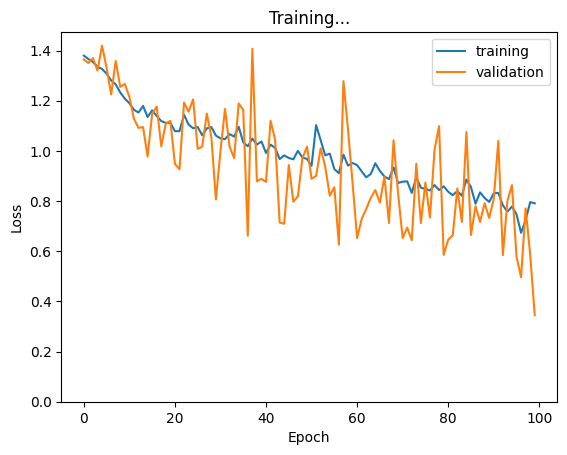

In [70]:
# Train function

import realtime_graph as graph

epochresults = []
epoch_valloss = 0 
graph.startplot()


for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    myCNN.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = myCNN.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    myCNN.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = myCNN.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()
        

    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

        
    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_loss<0.05:
        print("Early stopping")
        break

In [71]:
dataset_path_test = "./apple_resized_224/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path_test, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=False)

In [72]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = myCNN.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

            
        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[predicted[i]][labels[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)
print(total)

Accuracy of the network on the test images: 53 %
Confusion Matrix:
[[11.  3.  0.  7.]
 [ 3. 13.  2.  1.]
 [ 1.  1. 28.  8.]
 [15.  7.  8. 12.]]
120


In [73]:
# >>> from torchmetrics.classification import MulticlassConfusionMatrix
# >>> target = torch.tensor([2, 1, 0, 0])
# >>> preds = torch.tensor([
# ...   [0.16, 0.26, 0.58],
# ...   [0.22, 0.61, 0.17],
# ...   [0.71, 0.09, 0.20],
# ...   [0.05, 0.82, 0.13],
# ... ])
# >>> metric = MulticlassConfusionMatrix(num_classes=3)
# >>> metric(preds, target)
# tensor([[1, 1, 0],
#         [0, 1, 0],
#         [0, 0, 1]])